# Model selection and validation

In this notebook we will study how to select the lag time of Markov state models or Hidden Markov models, and how the models can be validated in order to decide whether they can be used in order to make reliable predictions about the long-term kinetics of the molecular system studied.

We start with a few general imports and settings

In [1]:
%pylab inline
from pyemma import msm
import pyemma.plots as mplt
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load double well data
import pyemma.datasets
double_well_data = pyemma.datasets.load_2well_discrete()

Draw double well and discretization
-------
We will use simulation data generated for a double-well potential. This data is part of the standard datasets in PyEMMA. In this notebook, we compare two discretizations: An excellent discretization with six states ('good discretization'), and a poor two-state discretization where the dividing surface is far away from the transition state ('bad discretization').

Let's look at the double well potential and these two discretizations:

/home/marscher/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


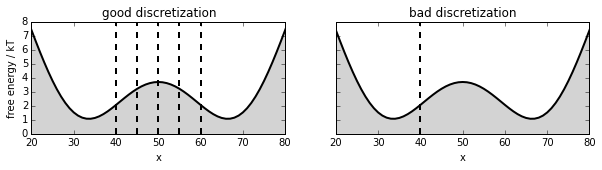

In [3]:
matplotlib.rcParams.update({'font.size': 10})
fig, axis = subplots(1, 2, figsize=(10,2))
P = double_well_data.transition_matrix
mu = msm.markov_model(P).stationary_distribution
E = -np.log(mu)
# plot 1
i = 0
axis[i].set_title('good discretization')
axis[i].plot(E-2.0, linewidth=2, color='black')
axis[i].fill_between(range(len(E)), np.zeros(len(E)), E-2.0, color='lightgrey')
axis[i].set_xlim(20,80); axis[i].set_xlabel('x'); axis[i].set_ylim(0,8); axis[i].set_ylabel('free energy / kT')
for b in [40, 45, 50, 55, 60]:
    axis[i].plot([b, b], [0, 8], linewidth=2, linestyle='dashed', color='black')
# plot 2
i = 1
axis[i].set_title('bad discretization')
axis[i].plot(E-2.0, linewidth=2, color='black')
axis[i].fill_between(range(len(E)), np.zeros(len(E)), E-2.0, color='lightgrey')
axis[i].set_xlim(20,80); axis[i].set_xlabel('x'); axis[i].set_ylim(0,8); axis[i].set_ylabel('free energy / kT')
axis[i].set_ylabel(''); axis[i].yaxis.set_ticklabels([]); 
axis[i].plot([40, 40], [0, 8], linewidth=2, linestyle='dashed', color='black')
#
savefig('figs/fig_selval_ab.png', bbox_inches='tight')

Timescales: MSM
-----

First we want to build Markov state models. Since the discretization is given, the only parameter that still needs to be selected is the lag time. Both the discretization and the lag time are crucial for the approximation quality of a Markov state model [1,2].

One common approach to select a lagtime is to compute the relaxation timescales implied by the estimated Markov state model [3], shortly called implied timescales: 

$    t_i = -\tau / \ln | \lambda_i (\tau)| $

where $\lambda_i(\tau)$ are the eigenvalues of the Markov state model estimated at lag time $\tau$. As the relaxation timescales are physical properties of the system the implied timescales should be independent of the lag time tau. In practice, this will not be fulfilled for short lag times due to discretization errors [2]. It will neither be fulfilled for very long lag times exceeding the implied timescales as the Markov model eigenvalues are then essentially resulting from the projection on random vectors [4].

In [4]:
its_good_msm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n6good], lags = 100)
its_bad_msm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n2bad], lags = 100)

Plotting these implied timescales already show that the good discretization converges at a lag time of about 20-40 steps to a timescale somewhat about 300, while the bad discretization doesn't appear to converge. According to the variational principle of conformation dynamics [5], we know in principle that the model with longer timescales are preferable, so at this point we might select the first discretization and a lag time of 20-40 steps...

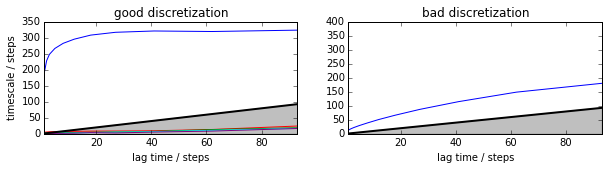

In [5]:
fig, axis = subplots(1, 2, figsize=(10,2))
mplt.plot_implied_timescales(its_good_msm, ax=axis[0], ylog=False)
ylim(0, 400); axis[0].set_title('good discretization')
mplt.plot_implied_timescales(its_bad_msm, ax=axis[1], ylog=False)
ylim(0, 400); ylabel(''); axis[1].set_title('bad discretization')

However, we don't know if the observations below are statistically significant. In particular, if only knew the bad discretization, it would be difficult to decide based on the plot above whether the implied timescale is sufficiently flat at any of the shown lag times. For this reason we compute the implied timescales including statistical errors. This option will use Bayesian transition matrix sampling as described in [6]. 

In [6]:
its_good_bmsm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n6good], lags = 100, errors='bayes')
its_bad_bmsm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n2bad], lags = 100, errors='bayes')

Now we see that the uncertainties (by default two sigma's = 95% confidence are shown) are small compared to the tau-dependent changes of the timescales in the bad discretization and we can reject that discretization even without knowing about the good discretization. The good discretization has a timescale that is indistinguishable from a constant af lag times of about 30 steps or longer.

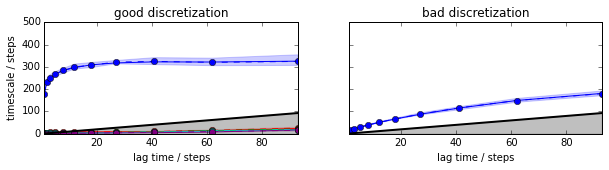

In [7]:
matplotlib.rcParams.update({'font.size': 10})
fig, axis = subplots(1, 2, figsize=(10,2))
#
mplt.plot_implied_timescales(its_good_bmsm, ax=axis[0], ylog=False)
axis[0].set_ylim(0, 500); 
axis[0].set_title('good discretization')
#
mplt.plot_implied_timescales(its_bad_bmsm, ax=axis[1], ylog=False)
axis[1].set_ylim(0, 500); axis[1].set_ylabel(''); axis[1].yaxis.set_ticklabels([]);
axis[1].set_title('bad discretization')
#
savefig('figs/fig_selval_cd.png', bbox_inches='tight')

Timescales: HMSM
------

Now, let us use a different model: a discrete Hidden Markov model (HMM) [7]. For metastable systems such as this one, discrete HMMs can be shown to be excellent approximations to PMMs, that are exact descriptions of the non-Markovian dynamics on discretized state spaces for metastable dynamics [8]. We estimate the HMM as described in [8], which involves to first estimate a coarse-grained Markov state model and then running a HMM estimation on top of it. This is a bit slower than MSM estimation:

In [8]:
its_good_hmm = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 2, lags = 100)
its_bad_hmm = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 2, lags = 100)

Now the good discretization seems to converge much faster, and to a timescale that is a little bit larger than that of the MSM model. Even the bad discretization reaches similar timescales, after about 40 steps, where the MSM on the same discretization was completely hopeless.

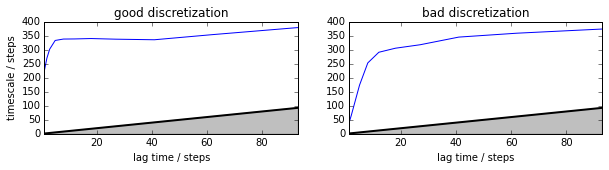

In [9]:
fig, axis = subplots(1, 2, figsize=(10,2))
mplt.plot_implied_timescales(its_good_hmm, ax=axis[0], ylog=False)
ylim(0, 400); axis[0].set_title('good discretization')
mplt.plot_implied_timescales(its_bad_hmm, ax=axis[1], ylog=False)
ylim(0, 400); ylabel(''); axis[1].set_title('bad discretization')

But let's compute statistical errors to see if these observations are significant. We do this by using the algorithms described in [9].

In [10]:
its_good_bhmm = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 2, lags = 100, errors='bayes')
its_bad_bhmm = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 2, lags = 100, errors='bayes')

We see that the slightly higher timescale estimate compared to the MSM is not statistically significant. However, the HMMs are useable for lag times of about 5 steps for the good and 10 steps for the bad discretization.

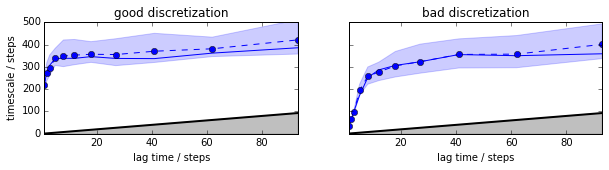

In [11]:
matplotlib.rcParams.update({'font.size': 10})
fig, axis = subplots(1, 2, figsize=(10,2))
#
mplt.plot_implied_timescales(its_good_bhmm, ax=axis[0], ylog=False)
axis[0].set_ylim(0, 500); 
axis[0].set_title('good discretization')
#axis[0].text(-22, 540, 'g)', fontsize=16)
#
mplt.plot_implied_timescales(its_bad_bhmm, ax=axis[1], ylog=False)
axis[1].set_ylim(0, 500); axis[1].set_ylabel(''); axis[1].yaxis.set_ticklabels([]); # axis[1].set_title('bad discretization')
axis[1].set_title('bad discretization')
#axis[1].text(-10, 540, 'h)', fontsize=16)
#
savefig('figs/fig_selval_gh.png', bbox_inches='tight')

Chapman-Kolmogorov Test
-------

Implied timescales can help to make the lag time decision, but they are not very strong tests of the validity of the model, because they only look at eigenvalues, while there is a lot of information in the eigenvectors. The Chapman-Kolmogorov Test as described in [1] is much stronger. In PyEMMA we have generalized the concept of the Chapman-Kolmogorov Test in order to be able to test various different models. The idea is: given a model estimated at lag time $\tau$, let's make a prediction of a model quantity for lag time $k \tau$, and let's compare that to an independently estimated a model at $k \tau$. The standard cktest computes the transition probability between metastable states for different lag times. 

So let's do MSM estimates at a (conservative) lag time of 40 steps.

In [12]:
MLMSM_good = msm.estimate_markov_model([double_well_data.dtraj_T100K_dt10_n6good], 40)
ck_good_msm = MLMSM_good.cktest(2)
MLMSM_bad = msm.estimate_markov_model([double_well_data.dtraj_T100K_dt10_n2bad], 40)
ck_bad_msm = MLMSM_bad.cktest(2)

Let's plot the result. This looks pretty good.

(<matplotlib.figure.Figure at 0x7f2d6da359d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d8bd6de50>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d6d34c050>]], dtype=object))

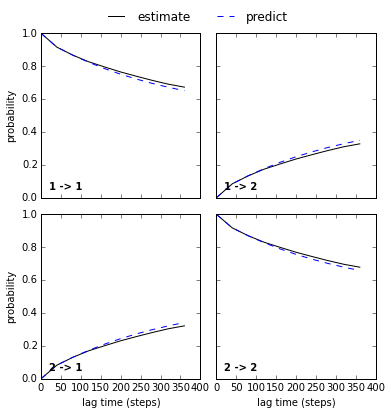

In [13]:
mplt.plot_cktest(ck_good_msm)

Wherease the comparison for the bad discretization is clearly a failure:

(<matplotlib.figure.Figure at 0x7f2d8b8edd50>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d8bf6bcd0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f2d6d200490>]], dtype=object))

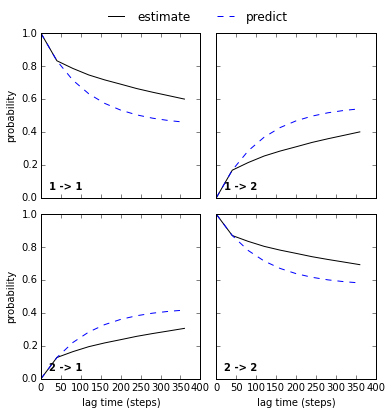

In [14]:
mplt.plot_cktest(ck_bad_msm)

But again, without error bars this is a bit like reading tea leaves. We didn't get errors from the cktest above, because the estimated models are just single-point models, in this case Maximum likelihood estimates. So there was no information about statistical errors available and thus could not be plotted. 

In order to display statistical errors we have to estimate MSMs with errors. We do this again using Bayesian MSMs [6]:

In [15]:
BMSM_good = msm.bayesian_markov_model([double_well_data.dtraj_T100K_dt10_n6good], 40)
ck_good_bmsm = BMSM_good.cktest(2, mlags=11)
BMSM_bad = msm.bayesian_markov_model([double_well_data.dtraj_T100K_dt10_n2bad], 40)
ck_bad_bmsm = BMSM_bad.cktest(2, mlags=11)

Et voilà, now we see the uncertainties (for the prediction - if we want it for the estimation too, we have to ask for that in the cktest function) and we have an agreement within the error. So this MSM is acceptable and can be further analyzed.

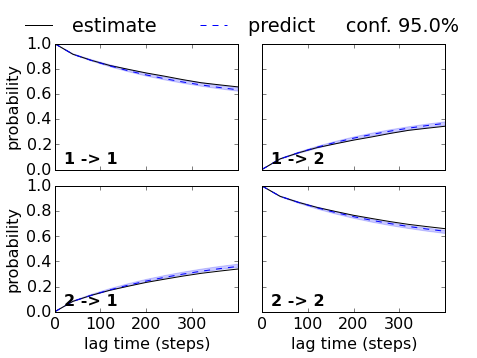

In [16]:
matplotlib.rcParams.update({'font.size': 16})
fig, axes = mplt.plot_cktest(ck_good_bmsm, figsize=(7, 5), padding_between=0.13, padding_top=0.13)
axes[0,1].xaxis.set_ticks([0,100,200,300])
axes[1,1].xaxis.set_ticks([0,100,200,300])
#fig.text(-0.075, 0.88, 'c)', fontsize=28)
#
savefig('figs/fig_selval_e.png', bbox_inches='tight')

While the cktest also fails within statistical error for the bad discretization. So we can't trust this MSM.

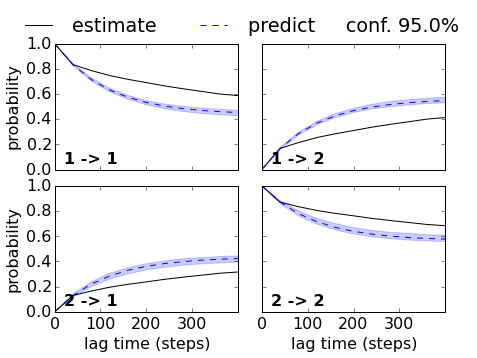

In [17]:
matplotlib.rcParams.update({'font.size': 16})
fig, axes = mplt.plot_cktest(ck_bad_bmsm, figsize=(7, 5), padding_between=0.13, padding_top=0.13)
axes[0,1].xaxis.set_ticks([0,100,200,300])
axes[1,1].xaxis.set_ticks([0,100,200,300])
#fig.text(-0.075, 0.88, 'd)', fontsize=28)
#
savefig('figs/fig_selval_f.png', bbox_inches='tight')

Now, let's do the same trick for the HMMs, and let's use a lag time of 5 steps which should work for the good, but not for the bad discretization. We want statistical errors, so we directly estimate a Bayesian HMM. This step is slow!

In [18]:
BHMM_good = msm.bayesian_hidden_markov_model([double_well_data.dtraj_T100K_dt10_n6good], 2, 5)
ck_good_bhmm = BHMM_good.cktest(mlags=80)
BHMM_bad = msm.bayesian_hidden_markov_model([double_well_data.dtraj_T100K_dt10_n2bad], 2, 5)
ck_bad_bhmm = BHMM_bad.cktest(mlags=80)

Indeed we get a nice agreement within the error for the good discretization. So we can accept this HMM:

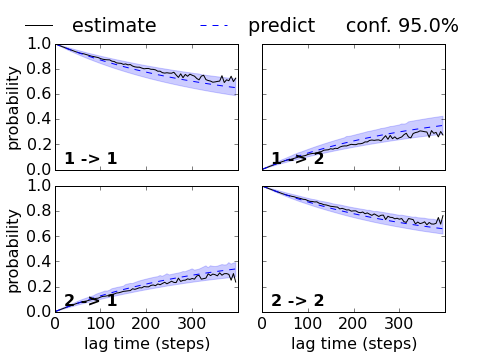

In [19]:
matplotlib.rcParams.update({'font.size': 16})
fig, axes = mplt.plot_cktest(ck_good_bhmm, figsize=(7, 5), padding_between=0.13, padding_top=0.13)
axes[0,1].xaxis.set_ticks([0,100,200,300])
axes[1,1].xaxis.set_ticks([0,100,200,300])
#fig.text(-0.075, 0.88, 'g)', fontsize=24)
#
savefig('figs/fig_selval_i.png', bbox_inches='tight')

While the HMM with the bad discretization fails. Note that the implied timescales did not indicate that we could use a lag time of five steps. If we used a lag time of 10 or 20 steps, the HMM on the bad discretization would be acceptable.

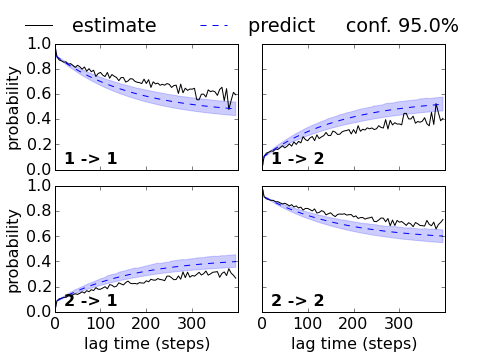

In [20]:
matplotlib.rcParams.update({'font.size': 16})
fig, axes = mplt.plot_cktest(ck_bad_bhmm, figsize=(7, 5), padding_between=0.13, padding_top=0.13)
axes[0,1].xaxis.set_ticks([0,100,200,300])
axes[1,1].xaxis.set_ticks([0,100,200,300])
#fig.text(-0.075, 0.88, 'h)', fontsize=24)
#
savefig('figs/fig_selval_j.png', bbox_inches='tight')

References
---------
[1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Sarich, M., F. Noé, Ch. Schütte: On the Approximation Quality of Markov State Models. Multiscale Model. Simul. 8, 1154-1177 (2010)

[3] Swope, W. C., J. W. Pitera and F. Suits: Describing protein folding kinetics by molecular dynamics simulations: 1. Theory, J. Phys. Chem. B. 108, 6571-6581 (2004)

[4] Beauchamp, K. A., R. McGibbon, Y. S. Lin and V. S. Pande: Simple few-state models reveal hidden complexity in protein folding. Proc. Natl. Acad. Sci. USA 109, 17807-17813 (2012)

[5] Noé, F. and F. Nüske: A variational approach to modeling slow processes in stochastic dynamical systems. SIAM Multiscale Model. Simul. 11. 635-655 (2013).

[6] Trendelkamp-Schroer, B., H. Wu, F. Paul and F. Noé: Estimation and uncertainty of reversible Markov models. arxiv.org/pdf/1507.05990 (2015)

[7] Rabiner, L. R.: A tutorial on hidden markov models and selected applications in speech recognition. Proc. IEEE 77, 257--286 (1989)

[8] Noé, F., H. Wu, J.-H. Prinz and N. Plattner, N.: Projected and Hidden Markov Models for calculating kinetics and metastable states of complex molecules. J. Chem. Phys. 139, 184114 (2013)

[9] Chodera, J. D., P. Elms, F. Noé, B. Keller, C. M. Kaiser, A. Ewall-Wice, S. Marqusee, C. Bustamante, N. Singhal Hinrichs: Bayesian hidden Markov model analysis of single-molecule force spectroscopy: Characterizing kinetics under measurement uncertainty. http://arxiv.org/abs/1108.1430.